In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, SparseArrays

┌ Info: Precompiling Fretem [e84e15ef-c9df-489c-8bae-19309071f75f]
└ @ Base loading.jl:1278
┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 0.5 # unit: angstrom
xavg = 1   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_eq = 247.15 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
pref = rho_eq .* rho_eq
pref = max.(pref, 1e-10)
D = 500 # Diffusion coefficient, unit: angstrom^2 s-1
D_array = D .* ones(size(xref));

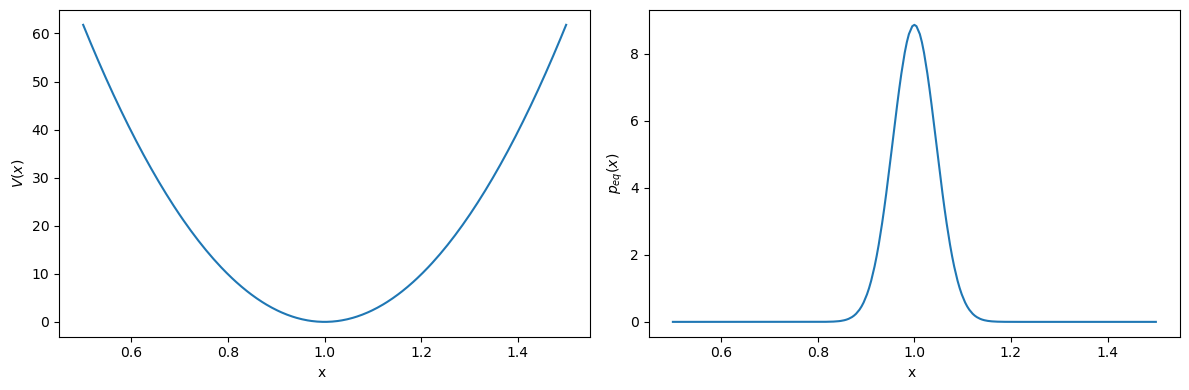

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

ax = axes[1]
ax.plot(xref, V_eq)
ax.set_xlabel("x ")
ax.set_ylabel("\$ V(x) \$")

ax = axes[2]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x ")
ax.set_ylabel("\$ p_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

In [4]:
Nv = 72 # Number of eigenvectors
LQ, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, rho_eq .* rho_eq, D, Nv);

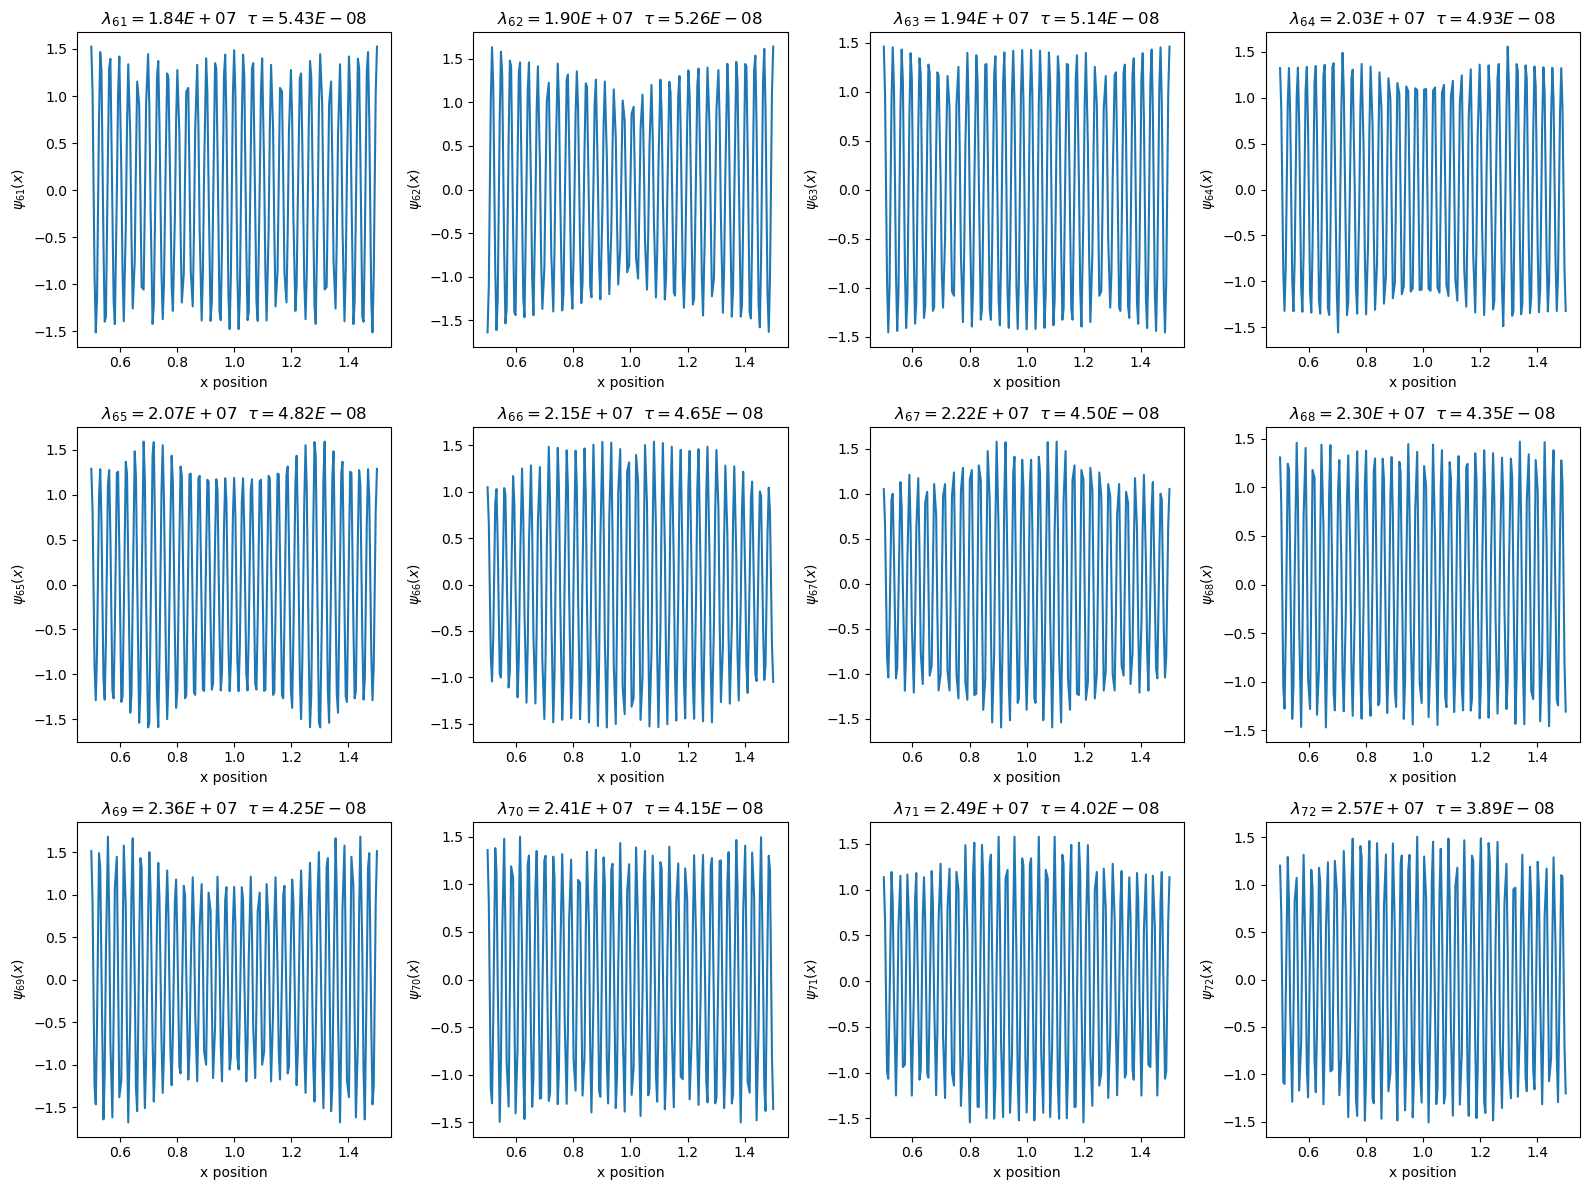

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

idx_eigvector = 61
for row_id=1:3
    for col_id = 1:4
        ax = axes[row_id, col_id]
        plot_x_Qx_lambda(ax, idx_eigvector, LQ, Qx, xref)
        idx_eigvector += 1
    end
end
plt.tight_layout()
#plt.savefig("eigv_1_12.png", dpi=150)
plt.show()

### Part: Triple Well

In [10]:
function triple_well(xref)
    factor1 = 1. / 15.47
    inner_term = 13.9 * (xref .- 1)
    V = factor1 * ((inner_term .^ 6) .- (15 * (inner_term .^ 4)) .+ (53 * (inner_term .^ 2)) .+ (2 * inner_term) .- 15.)
    V = V .+ 2.9266
    return V
end

triple_well (generic function with 1 method)

In [11]:
V_eq = triple_well(xref)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 500;# Diffusion coefficient, unit: s-1

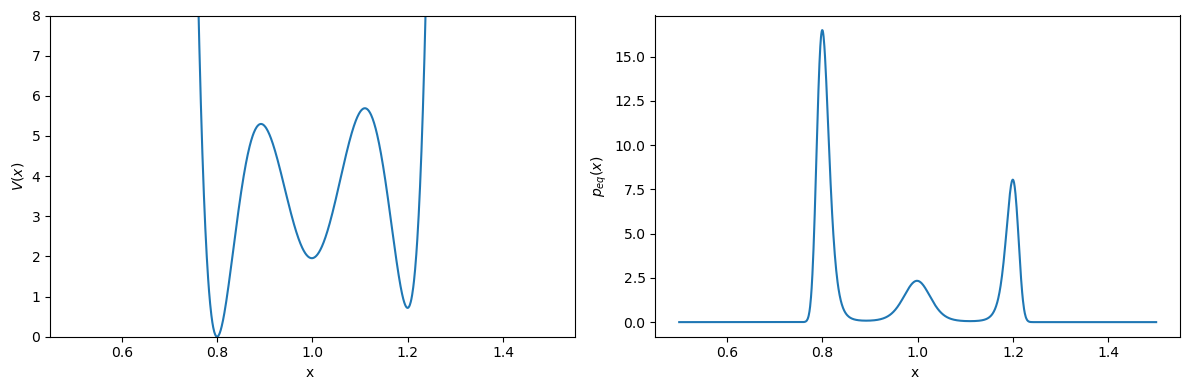

In [82]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

ax = axes[1]
ax.plot(xref, V_eq)
ax.set_xlabel("x ")
ax.set_ylabel("\$ V(x) \$")
ax.set_ylim(0,8)

ax = axes[2]
ax.plot(xref, peq)
ax.set_xlabel("x ")
ax.set_ylabel("\$ p_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

In [12]:
Nv = 72 # Number of eigenvectors
LQ, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

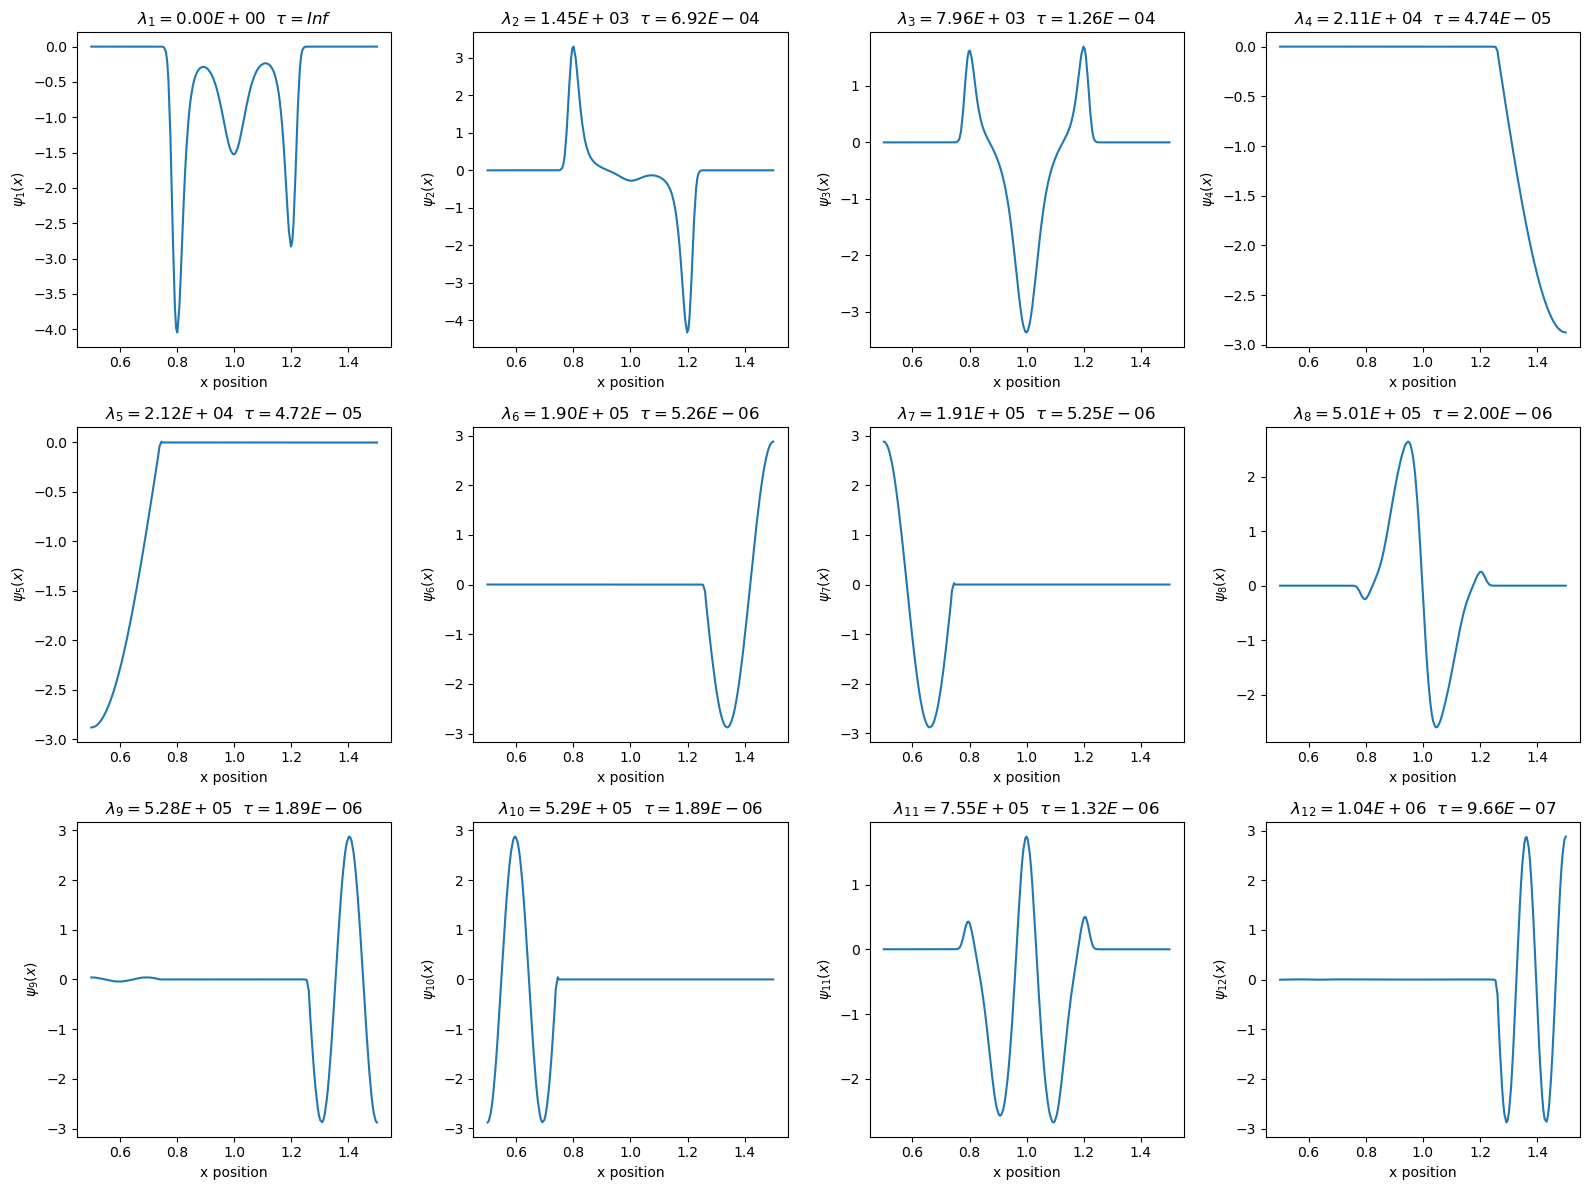

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

idx_eigvector = 1
for row_id=1:3
    for col_id = 1:4
        ax = axes[row_id, col_id]
        plot_x_Qx_lambda(ax, idx_eigvector, LQ, Qx, xref)
        idx_eigvector += 1
    end
end
plt.tight_layout()
#plt.savefig("eigv_1_12.png", dpi=150)
plt.show()